In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py as h5
import healpy as hp
import os
import meander
import csky as cy

#mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')
mpl.rcParams['font.size'] = 20

In [2]:
timer = cy.timing.Timer()
time = timer.time

In [3]:
dat_loc='/data/user/jthwaites/chime_localization_data/'
dat_files=os.listdir(dat_loc)

In [4]:
#making sample localizations with files from chime cat 1
#f1 = h5.File(dat_loc+'FRB20190128C_localization.h5','r')
#f2 = h5.File(dat_loc+'FRB20180907D_localization.h5','r')
samp_f =[dat_loc+dat_files[i] for i in [2,100,200,300,400]]

In [5]:
#copied directly from https://chime-frb-open-data.github.io/localization.html
# The following function just summarizes the HDF5 file structure:
def describe(group, recurse=False):
    """ Prints info on the contents of an hdf5 group """

    print(group.name)

    # First print header-like attributes (if exist)
    if group.attrs:
        print('\n  attrs: {')
    for key, value in group.attrs.items():
        if key in ['comments', 'history']:
            print('    %s:' % key)
            for line in value:
                print('      ' + str(line))
        else:
            print('    %s:' % key, value)
    if group.attrs:
        print('  }')

    # Then print constituent groups & datasets
    print()
    for key, value in group.items():
        if isinstance(value, h5.Group):
            if recurse:
                print('-'*60)
                describe(value, True)
            else:
                print('  ' + key + '/')
        else:
            print('  ' + key + ':', value.shape, value.dtype)
    print()
#describe(samp_f['/'])

In [6]:
new_localizations={'tns_name':[],'ra_unc':[],'dec':[],'dec_unc':[]}
for file in dat_files:
    f = h5.File(dat_loc+file,'r')
    
    ra_loc=f['/'].attrs['ra_error']
    dec_loc=f['/'].attrs['dec_error']

    extent=[[0,361],[0,91]]
    for name, contour in f['/contours/68/'].items():
        contour=contour[:]
        max_ra=max(contour[0])
        if max_ra> extent[0][0]: extent[0][0]=max_ra
        min_ra=min(contour[0])
        if min_ra< extent[0][1]: extent[0][1]=min_ra
        max_dec=max(contour[1])
        if max_dec> extent[1][0]: extent[1][0]=max_dec
        min_dec=min(contour[1])
        if min_dec < extent[1][1]: extent[1][1]=min_dec
    
    if (extent[0][0]-extent[0][1]) > ra_loc: ra_loc=extent[0][0]-extent[0][1]
    if (extent[1][0]-extent[1][1]) > dec_loc: dec_loc=extent[1][0]-extent[1][1]
    
    new_localizations['tns_name'].append(f['/'].attrs['tns_name'])
    new_localizations['dec'].append(f['/'].attrs['dec'])
    new_localizations['ra_unc'].append(ra_loc)
    new_localizations['dec_unc'].append(dec_loc)

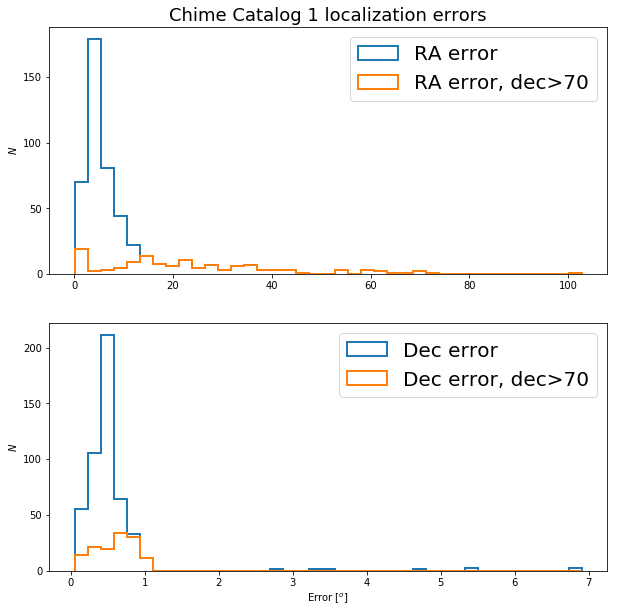

In [7]:
"""Plot new localizations from full 68% contours"""
dec_bins=np.linspace(min(new_localizations['dec_unc']),
                     max(new_localizations['dec_unc']), num=40)
ra_bins=np.linspace(min(new_localizations['ra_unc']),
                     max(new_localizations['ra_unc']), num=40)
w=np.where(np.asarray(new_localizations['dec'])>70.)[0]

fig, ax = plt.subplots(2,figsize=(10,10))
mpl.rcParams['font.size'] = 20
ax[0].hist(new_localizations['ra_unc'], bins=ra_bins, histtype='step', 
         lw=2., label='RA error', color='C0')
ax[0].hist([new_localizations['ra_unc'][i] for i in w], bins=ra_bins, histtype='step', 
         lw=2., label='RA error, dec>70', color='C1')
ax[1].hist(new_localizations['dec_unc'], bins=dec_bins, histtype='step', 
         lw=2., label='Dec error', color='C0')
ax[1].hist([new_localizations['dec_unc'][i] for i in w], bins=dec_bins, histtype='step', 
         lw=2., label='Dec error, dec>70', color='C1')

ax[0].set_ylabel(r'$N$')
ax[1].set_ylabel(r'$N$')
ax[1].set_xlabel(r'Error [$^o$]')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[0].set_title(r'Chime Catalog 1 localization errors', fontsize=18)
plt.savefig('./frb_param_plots/cat1_loc_err_new.png')

In [7]:
def show_contours(f):
    fig, ax = plt.subplots(figsize=(10,2.5))
    i=0
    for name, contour in f['/contours/68/'].items():
        contour=contour[:]
        if i==0: plt.plot(contour[0],contour[1],color='C0', label='68% CL')
        else: plt.plot(contour[0],contour[1],color='C0')
        i+=1
    i=0
    for name, contour in f['/contours/90/'].items():
        contour=contour[:]
        if i==0: plt.plot(contour[0],contour[1],color='C1', label='90% CL')
        else: plt.plot(contour[0],contour[1],color='C1')
        i+=1
    ax.invert_xaxis()
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    plt.legend(loc=4)
    plt.title('%s Contours'%f['/'].attrs['tns_name'])
    plt.show()

In [8]:
#recreate chime cat 1 localization plots from paper
def show_localizations(f2):
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots( figsize=(10,4))

    # Note: RA increases to the left!
    hdr = f2['projection'].attrs
    CL = f2['projection/data'][:]
    extent = np.array([-hdr['xsize']/2, hdr['xsize']/2, 
                -hdr['ysize']/2, hdr['ysize']/2])*hdr['reso']/60

    im = ax.imshow(CL, vmin=0, origin='lower',
                extent=extent, cmap='magma')
    ax.contour(CL, levels=[0.68, 0.95], linestyles=['-', '--'], 
                colors='k', linewidths=2, extent=extent)
    ax.set_title('%s \n RA= %.2f$\pm$%.2f$^o$, dec= %.2f$\pm$%.2f$^o$' 
                %(f2.attrs['tns_name'],hdr['clon'], 
                    f2.attrs['ra_error'], hdr['clat'], f2.attrs['dec_error']))
    ax.set_xlabel('$\Delta$RA (deg)')
    ax.set_ylabel('$\Delta$dec (deg)')

    plt.colorbar(im, pad=0.25, shrink=0.4, orientation='horizontal',
                label='Confidence Level')
    plt.show()
    #plt.savefig('./frb_param_plots/sample1_locpdfs.png')

In [13]:
# https://github.com/icecube/FastResponseAnalysis/blob/1ef71ea017805e7180f2b616796ba5474284aa88/fast_response/FastResponseAnalysis.py#L1218
# Other functions here have things that add axis labels and such

def plot_zoom(scan, ra, dec, levels=[0.90], title='', reso=3, 
              var="pVal", range=[0, 6],cmap='Blues', contour_scan=None, CL=None):
    if cmap is None:
        pdf_palette = sns.color_palette("Blues", 500)
        cmap = mpl.colors.ListedColormap(pdf_palette)
    hp.gnomview(scan, rot=(np.degrees(ra), np.degrees(dec), 0),
                    cmap=cmap,
                    max=max(scan),
                    reso=reso,
                    title=title,
                    notext=True,
                    cbar=False,
                    nest=False
                    #unit=r""
                    )
    levels=[0.68,0.90] # 68%,90% containment 
    
    if CL is not None:
        theta, phi = plot_contours_with_mask(CL, levels)
    elif contour_scan is None:
        theta, phi = plot_contours(levels,scan)
    else:
        theta, phi = plot_contours(levels,contour_scan)
    
    hp.projplot(theta[0],phi[0],linewidth=1,c='k',label='%i%% C.L'%(levels[0]*100))
    for i in np.arange(1,len(theta)): 
        hp.projplot(theta[i],phi[i],c='k',linewidth=1)
        
    plt.plot(4.95/3.*reso*np.radians([-1, 1, 1, -1, -1]), 
             4.95/3.*reso*np.radians([1, 1, -1, -1, 1]), color="k", ls="-", lw=3)

    draw_axes(dec, ra, reso)
    plot_color_bar(cmap='Blues', labels=[0.,np.around(max(scan),decimals=3)])
    #hp.graticule(verbose=False)

def draw_axes(src_dec, src_ra, reso, axis_labels=True):
    plt.plot(
        4.95/3.*reso*np.radians([-1, 1, 1, -1, -1]), 
        4.95/3.*reso*np.radians([1, 1, -1, -1, 1]), 
        color="k", ls="-", lw=3
        )
    ra_scale_factor = 3 if np.degrees(np.abs(src_dec)) < 30. else 10
    num_ra_lines = ra_scale_factor*reso
    num_dec_lines = 3*reso
    ra_axes = np.linspace(
        np.degrees(src_ra)-360.,
        np.degrees(src_ra)+360.,
        721
        )
    ra_axes = ra_axes[
        (ra_axes > (np.degrees(src_ra) - num_ra_lines)) & \
        (ra_axes < (np.degrees(src_ra) + num_ra_lines))
        ]
    ra_axes = np.where(ra_axes > 360., ra_axes - 360., ra_axes)
    dec_axes = np.linspace(
        np.degrees(src_dec) - 180.,
        np.degrees(src_dec) + 180.,
        361.
        )
    dec_axes = dec_axes[
        (dec_axes > (np.degrees(src_dec) - num_dec_lines)) & \
        (dec_axes < (np.degrees(src_dec) + num_dec_lines))
        ]
    dec_axes = dec_axes[(dec_axes > -90.) & (dec_axes < 90.)]
    for tmp_ra in ra_axes:
        tmp_line_ra = np.radians(np.ones(500)*tmp_ra)
        tmp_line_dec = np.radians(np.linspace(dec_axes[0], dec_axes[-1], 500))
        hp.projplot(np.pi/2. - tmp_line_dec, tmp_line_ra, linewidth=0.5, 
                    color='k', linestyle='dotted', coord='C')
    for tmp_dec in dec_axes:
        tmp_line_dec = np.radians(np.ones(500)*tmp_dec)
        tmp_line_ra = np.radians(np.linspace(ra_axes[0], ra_axes[-1], 500))
        hp.projplot(np.pi/2. - tmp_line_dec, tmp_line_ra, linewidth=0.5, 
                    color='k', linestyle='dotted', coord='C')
    plot_labels(src_dec, src_ra, reso, with_axis_labels=axis_labels)    

def plot_color_bar(labels=[0.,2.,4.,6.], col_label=r"Probability", range=[0,6], cmap=None, offset=-35):
    fig = plt.gcf()
    #ax = fig.add_axes([0.25, -0.03, 0.5, 0.03])
    ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    cb = mpl.colorbar.ColorbarBase(ax, cmap=ps_map if cmap is None else cmap,
                        #norm=mpl.colors.Normalize(vmin=range[0], vmax=range[1]), 
                        orientation="vertical")
    #cb.ax.minorticks_on()
    cb.set_label(col_label,labelpad=offset, fontsize=18)
    cb.set_ticks([0., 1.])
    cb.set_ticklabels(labels)
    cb.update_ticks()
    #cb.ax.get_xaxis().set_ticklabels(labels)

def plot_labels(src_dec, src_ra, reso, with_axis_labels=True):
    """Add labels to healpy zoom"""
    fontsize = 20
    
    if np.degrees(src_dec) > 30.:
        ras = [
            np.degrees(src_ra) - reso*3,
            np.degrees(src_ra),
            np.degrees(src_ra) + reso*3
            ]
    else:
        ras = [
            np.degrees(src_ra) - reso,
            np.degrees(src_ra),
            np.degrees(src_ra) + reso
            ]
    decs = [
        np.degrees(src_dec) - reso,
        np.degrees(src_dec),
        np.degrees(src_dec) + reso
        ]
    for ra in ras:
        dec_text = np.pi/2. - src_dec + (np.radians(reso) * 5.5/3.)
        dec_offset = np.abs(np.radians(ra - np.degrees(src_ra)))*np.sin(src_dec)*reso*0.01
        ra_text = "{:.2f}$^\circ$".format(ra) if ra < 360. else "{:.2f}$^\circ$".format(ra - 360.)
        hp.projtext(dec_text + dec_offset, np.radians(ra),
                    ra_text, lonlat=False,
                    fontsize=20, ha='center')
    for dec in decs:
        scale = np.degrees(hp.rotator.angdist(
            [np.pi/2. - np.radians(dec), src_ra], 
            [np.pi/2. - np.radians(dec), src_ra + np.radians(1.)]
            ))
        ra_text = np.radians(np.degrees(src_ra) + 1.7*reso/scale)
        hp.projtext(np.pi/2. - np.radians(dec), ra_text,
            "{:.2f}$^\circ$".format(dec), lonlat=False,
            fontsize=20, ha='right')
    
    if with_axis_labels:
        plt.text(-1.05*np.radians(2.4*reso), np.radians(0), r"declination",
                    ha='center', va='center', rotation=90, fontsize=fontsize)
        plt.text(np.radians(0), np.radians(-2*reso), r"right ascension",
                    ha='center', va='center', fontsize=fontsize)

In [10]:
#from Raamis: code to draw contours w Meander
def plot_contours(proportions,samples):
    r''' Plot containment contour around desired level.
    E.g 90% containment of a PDF on a healpix map    
    Parameters:
    -----------
    proportions: list
        list of containment level to make contours for.
        E.g [0.68,0.9]
    samples: array
        array of values read in from healpix map
        E.g samples = hp.read_map(file)
    Returns:
    --------
    theta_list: list
        List of arrays containing theta values for desired contours
    phi_list: list
        List of arrays containing phi values for desired contours
    '''    
    levels = []
    sorted_samples = list(reversed(list(sorted(samples))))
    
    nside = hp.pixelfunc.get_nside(samples)
    sample_points = np.array(hp.pix2ang(nside,np.arange(len(samples)))).T
    
    for proportion in proportions:
        level_index = (np.cumsum(sorted_samples) > proportion).tolist().index(True)
        level = (sorted_samples[level_index] + (sorted_samples[level_index+1] 
                                        if level_index+1 < len(samples) else 0)) / 2.0
        levels.append(level)
    contours_by_level = meander.spherical_contours(sample_points, samples, levels)    
    
    theta_list = []; phi_list=[]
    for contours in contours_by_level:
        for contour in contours:
            theta, phi = contour.T
            phi[phi<0] += 2.0*np.pi
            theta_list.append(theta)
            phi_list.append(phi)    
    return theta_list, phi_list

def plot_contours_with_mask(CL, CL_levels):
    ''' Plot containment contour around desired level.
    theta_list: List of arrays containing theta values for desired contours
    phi_list: List of arrays containing phi values for desired contours'''
    
    nside = hp.pixelfunc.get_nside(CL)
    sample_points = np.array(hp.pix2ang(nside,np.arange(len(CL)))).T
    
    max_cl_level = 0.99999
    msk = CL < max_cl_level
    
    contours_by_level = meander.spherical_contours(sample_points[msk], CL[msk], CL_levels)
    
    theta_list = []; phi_list=[]
    for contours in contours_by_level:
        for contour in contours:
            theta, phi = contour.T
            phi[phi<0] += 2.0*np.pi
            theta_list.append(theta)
            phi_list.append(phi)    
    return theta_list, phi_list

In [23]:
tns_name='FRB20190517C'
index=np.where(tns_name==np.asarray(new_localizations['tns_name']))[0][0]
frb = dat_loc + tns_name+'_localization.h5'
f = h5.File(frb, 'r')

def make_healpix_mapping(f, new_nside=512, use_msk=True):
    ra = np.radians(f['/'].attrs['ra'])
    dec = np.radians(f['/'].attrs['dec'])

    original_nside = f['healpix'].attrs['nside']
    ipix, CL = f['healpix/ipix'][()], f['healpix/CL'][()]
    #for some reason, it appears there are duplicates of these in all the files. 
    #To remove, use np.unique fxn
    unique_CLs, CL_ind=np.unique(ipix, return_index=True)

    probs = (1. - CL)/ (1. - CL[CL_ind]).sum()
    frb_probs = np.zeros(hp.nside2npix(original_nside))
    frb_probs[ipix] = probs
    new_CL = np.ones_like(frb_probs)
    new_CL[ipix] = CL
    
    frb_probs = hp.ud_grade(frb_probs,
                new_nside, order_in='NESTED', order_out='RING', power=-2)
    new_CL = hp.ud_grade(new_CL,
                new_nside, order_in='NESTED', order_out='RING')
    
    print('Total map probability = %.6'%frb_probs.sum())
    if use_msk==True: 
        plot_zoom(frb_probs, ra, dec, reso=new_localizations['ra_unc'][index]/2, CL=new_CL)
    else: 
        plot_zoom(frb_probs, ra, dec, reso=new_localizations['ra_unc'][index]/2)

#make_healpix_mapping(f, new_nside=256)

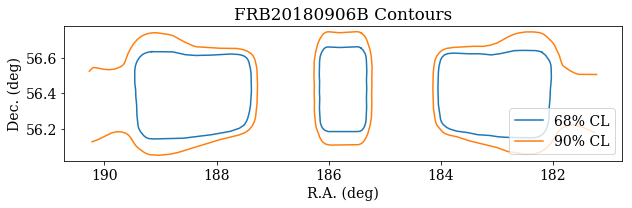

0.9999999721672695

0:00:11.215572 elapsed.
0.9999999721672695

0:00:15.910496 elapsed.


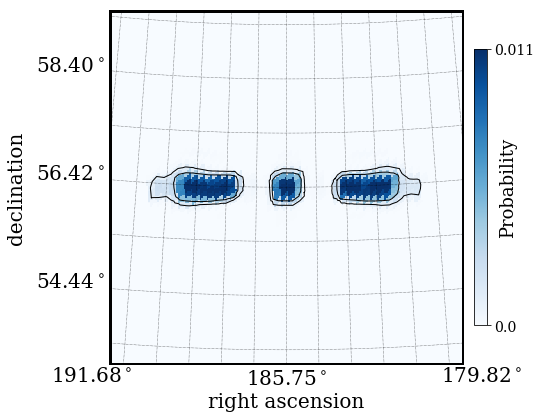

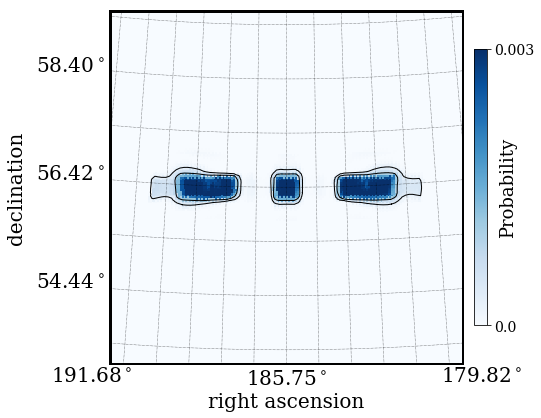

In [19]:
f2=h5.File(samp_f[0],'r')
#show_localizations(f2)
show_contours(f2)
with(time('healpix map, %s, nside=512'%samp_f[0][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=512)
with(time('healpix map, %s, nside=1024'%samp_f[0][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=1024)

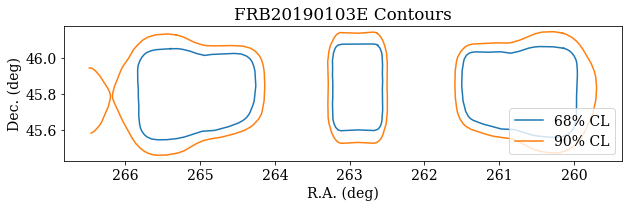

0.9999999072419374

0:00:10.846086 elapsed.
0.9999999072419374

0:00:17.296033 elapsed.


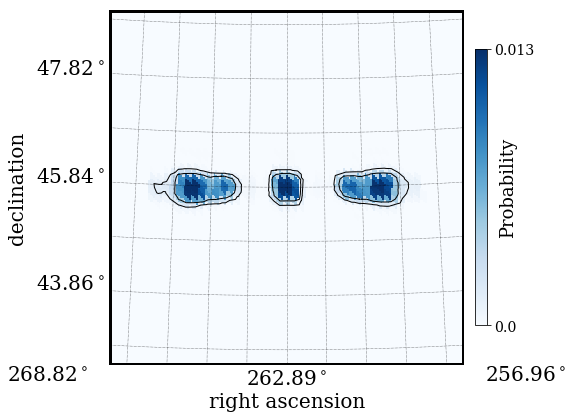

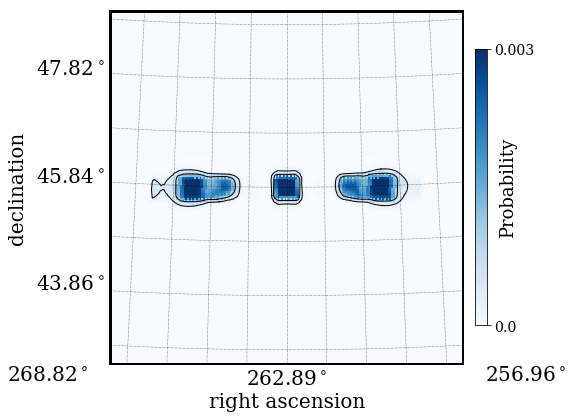

In [20]:
f2=h5.File(samp_f[1],'r')
#show_localizations(f2)
show_contours(f2)
with(time('healpix map, %s, nside=512'%samp_f[1][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=512)
with(time('healpix map, %s, nside=1024'%samp_f[1][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=1024)

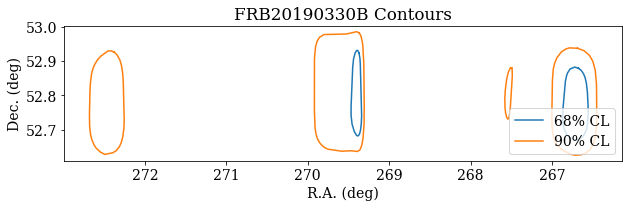

0.999999938957068

0:00:12.391353 elapsed.
0.999999938957068

0:00:16.922137 elapsed.


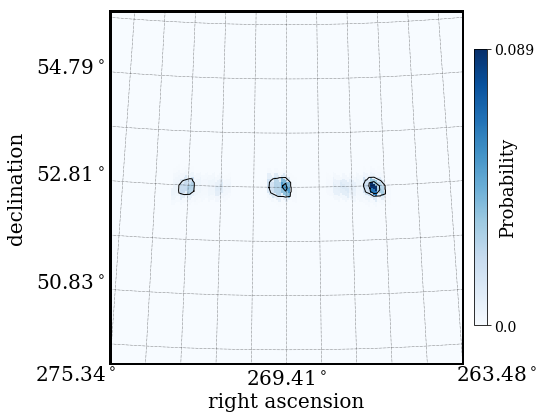

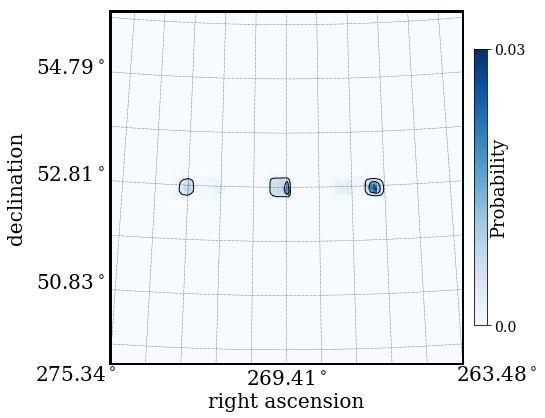

In [21]:
f2=h5.File(samp_f[2],'r')
#show_localizations(f2)
show_contours(f2)
with(time('healpix map, %s, nside=512'%samp_f[2][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=512)
with(time('healpix map, %s, nside=1024'%samp_f[2][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=1024)

In [22]:
print(timer)

healpix map, FRB20180906B_localization.h5, nside=256          | 0:00:12.151219
healpix map, FRB20180906B_localization.h5, nside=256, no mask | 0:02:02.694620
healpix map, FRB20180906B_localization.h5, nside=512, no mask | 0:07:25.839294
healpix map, FRB20180906B_localization.h5, nside=512          | 0:00:11.215572
healpix map, FRB20180906B_localization.h5, nside=1024         | 0:00:15.910496
healpix map, FRB20190103E_localization.h5, nside=512          | 0:00:10.846086
healpix map, FRB20190103E_localization.h5, nside=1024         | 0:00:17.296033
healpix map, FRB20190330B_localization.h5, nside=512          | 0:00:12.391353
healpix map, FRB20190330B_localization.h5, nside=1024         | 0:00:16.922137
------------------------------------------------------------------------------
total                                                         | 0:11:05.266810
